In [ ]:
! pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from io import StringIO

In [ ]:
df = pd.read_csv("./notna_df.csv", sep = ';', index_col=0) 
drop_cols = ['isna', 'student_group','student_name', 'person_id', 'project_id', 'target_multiclass', 'rate_total', 'project_head']
df = df.drop(columns = drop_cols)

cat_features = ['stepen', 'course']
df[cat_features] = df[cat_features].astype(str)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
metrics = pd.DataFrame(columns = ['task', 'precision', 'recall', 'f1', 'rocauc'])

# baseline

In [ ]:
task = 'baseline'
model = CatBoostClassifier(random_seed=1, verbose=0)

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       1.00      0.07      0.14        80
           1       0.92      1.00      0.96       907

    accuracy                           0.93       987
   macro avg       0.96      0.54      0.55       987
weighted avg       0.93      0.93      0.89       987

TEST
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.92      1.00      0.96       227

    accuracy                           0.92       247
   macro avg       0.96      0.53      0.53       247
weighted avg       0.93      0.92      0.89       247

ROC-AUC train 0.9429299889746416
ROC-AUC test 0.758590308370044


In [ ]:
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')
metrics

<ipython-input-23-59b20ab10dab>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, new_row], ignore_index=True)


,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.0,0.960805,0.94293,1.0,0.07,0.14
1,baseline_test,0.922764,1.0,0.959831,0.75859,1.0,0.05,0.10


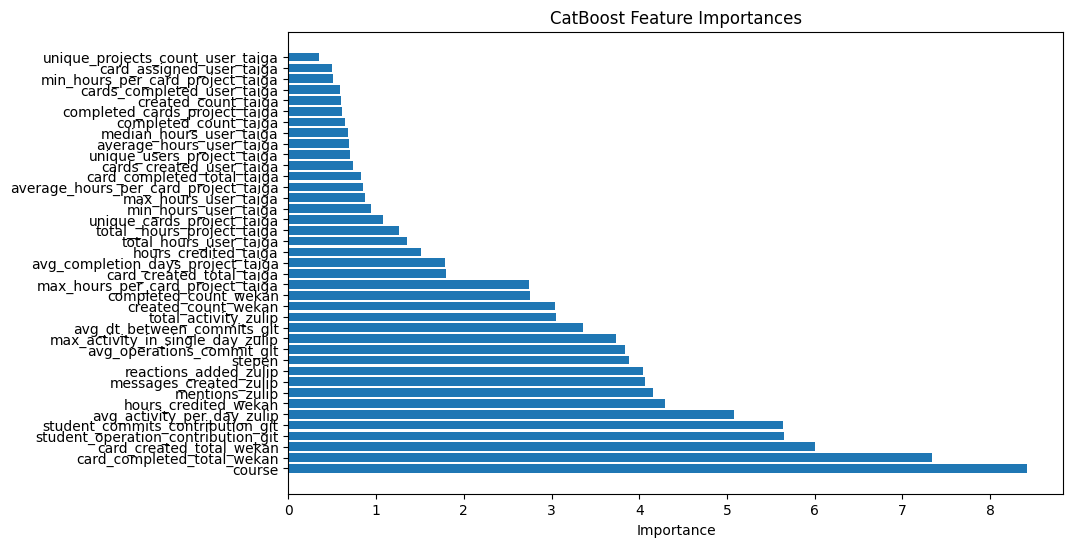

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))

x = (dict(zip(X_train.columns, importances)))
x = dict(sorted(x.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(10, 6))
plt.barh(x.keys(), x.values())
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
x = (dict(zip(X_train.columns, importances)))
sorted(x.items(), key=lambda kv: kv[1])

[('unique_projects_count_user_taiga', np.float64(0.3517334512139523)),
 ('card_assigned_user_taiga', np.float64(0.50019856883457)),
 ('min_hours_per_card_project_taiga', np.float64(0.5042422705014472)),
 ('cards_completed_user_taiga', np.float64(0.5827923968221361)),
 ('created_count_taiga', np.float64(0.6014802620032808)),
 ('completed_cards_project_taiga', np.float64(0.6096816291949169)),
 ('completed_count_taiga', np.float64(0.6457662939791833)),
 ('median_hours_user_taiga', np.float64(0.6760258342459182)),
 ('average_hours_user_taiga', np.float64(0.693874926661571)),
 ('unique_users_project_taiga', np.float64(0.705340768837725)),
 ('cards_created_user_taiga', np.float64(0.7362842055100328)),
 ('card_completed_total_taiga', np.float64(0.8256781759918419)),
 ('average_hours_per_card_project_taiga', np.float64(0.8517325490728128)),
 ('max_hours_user_taiga', np.float64(0.8703760878564328)),
 ('min_hours_user_taiga', np.float64(0.9453764566610413)),
 ('unique_cards_project_taiga', np.fl

Заметно переобучение и дисбаланс классов. Чтобы его исключить будем использовать SMOTE

In [ ]:
task = 'baseline_class_weight'
model = CatBoostClassifier(random_seed=1, verbose=0, class_weights=[12, 1])

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.20      0.94      0.34        80
           1       0.99      0.68      0.81       907

    accuracy                           0.70       987
   macro avg       0.60      0.81      0.57       987
weighted avg       0.93      0.70      0.77       987

TEST
              precision    recall  f1-score   support

           0       0.18      0.80      0.30        20
           1       0.97      0.69      0.81       227

    accuracy                           0.70       247
   macro avg       0.58      0.74      0.55       247
weighted avg       0.91      0.70      0.77       247

ROC-AUC train 0.8777218853362735
ROC-AUC test 0.7592511013215859


In [ ]:
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30


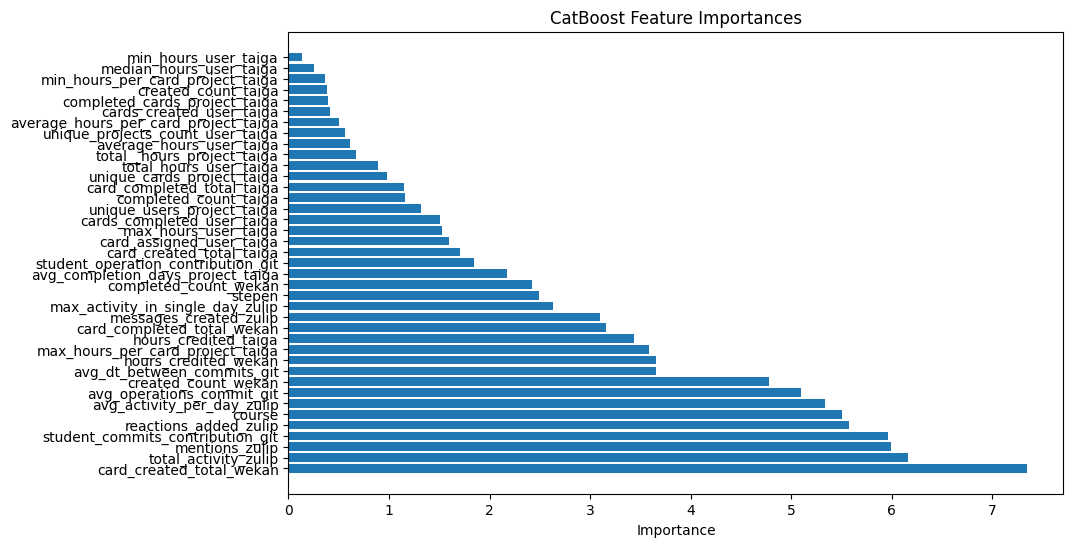

In [ ]:
importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))

x = (dict(zip(X_train.columns, importances)))
x = dict(sorted(x.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(10, 6))
plt.barh(x.keys(), x.values())
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
x

{'min_hours_user_taiga': np.float64(0.13496761688397013),
 'median_hours_user_taiga': np.float64(0.2518260785802627),
 'min_hours_per_card_project_taiga': np.float64(0.36434178349643126),
 'created_count_taiga': np.float64(0.3820986858290637),
 'completed_cards_project_taiga': np.float64(0.3921978887116121),
 'cards_created_user_taiga': np.float64(0.41416814876408004),
 'average_hours_per_card_project_taiga': np.float64(0.5047201922713649),
 'unique_projects_count_user_taiga': np.float64(0.5646917945249633),
 'average_hours_user_taiga': np.float64(0.6149667900043138),
 'total__hours_project_taiga': np.float64(0.6667708667206189),
 'total_hours_user_taiga': np.float64(0.8861441055816385),
 'unique_cards_project_taiga': np.float64(0.9778403126711204),
 'card_completed_total_taiga': np.float64(1.1531343933182934),
 'completed_count_taiga': np.float64(1.1631319727727256),
 'unique_users_project_taiga': np.float64(1.313748625657026),
 'cards_completed_user_taiga': np.float64(1.5098281540676

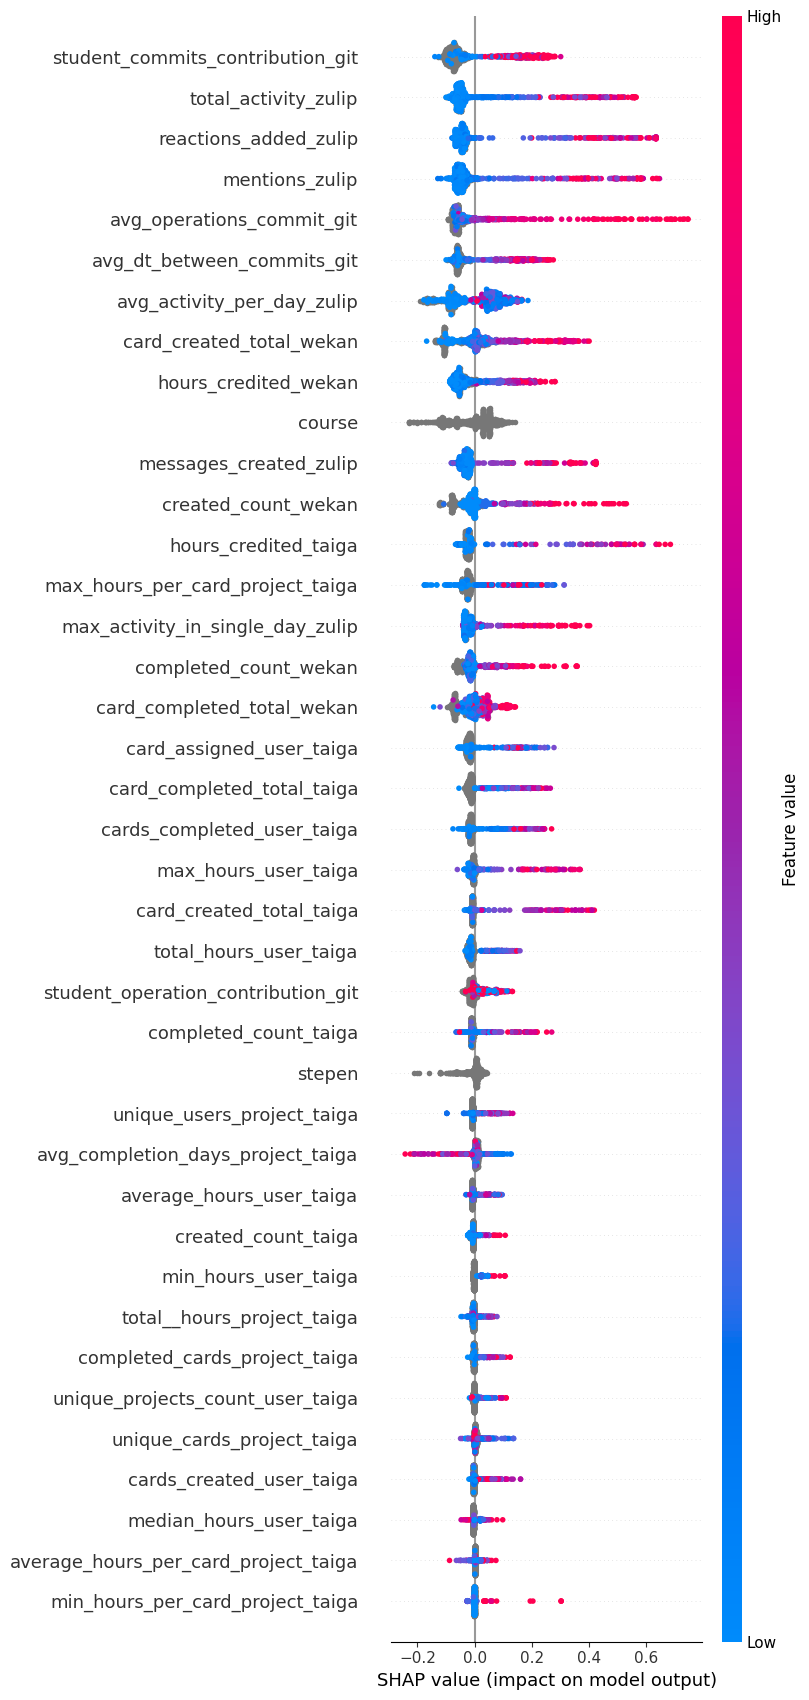

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=40)

# Попробуем еще больше уменьшить выборку, удалив разреженные строки:

In [ ]:
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.537500,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.525000,1.00,0.05,0.10
2,baseline_class_weight_train,0.996344,0.600882,0.749656,0.787941,0.18,0.97,0.30
3,baseline_class_weight_test,0.978571,0.603524,0.746594,0.726762,0.16,0.85,0.27


In [ ]:
# Удаление колонок с >80% пропусков
df_filtered = df[df.isnull().mean(axis=1) < 0.8]
# Отделим целевую переменную
X = df_filtered.drop(columns=['target'])
y = df_filtered['target']

X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(df_filtered.shape)

(1073, 40)


In [ ]:
task = 'drop_more_cols'
model = CatBoostClassifier(random_seed=1, verbose=0, class_weights=[12, 1])

model.fit(X_train_F, y_train_F, cat_features=cat_features, eval_set=(X_test_F, y_test_F), early_stopping_rounds=50)


y_pred = model.predict(X_test_F)
y_pred_train = model.predict(X_train_F)

print('TRAIN')
print(classification_report(y_train_F, y_pred_train))
print('TEST')
print(classification_report(y_test_F, y_pred))

pr_train = precision_score(y_train_F, y_pred_train)
pr_test = precision_score(y_test_F, y_pred)

rec_train = recall_score(y_train_F, y_pred_train)
rec_test = recall_score(y_test_F, y_pred)

f_train = f1_score(y_train_F, y_pred_train)
f_test = f1_score(y_test_F, y_pred)

roc_train= roc_auc_score(y_train_F, model.predict_proba(X_train_F)[:, 1])
roc_test= roc_auc_score(y_test_F, model.predict_proba(X_test_F)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)

new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train_F, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test_F, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')

TRAIN
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        69
           1       0.98      0.72      0.83       789

    accuracy                           0.73       858
   macro avg       0.59      0.77      0.58       858
weighted avg       0.92      0.73      0.79       858

TEST
              precision    recall  f1-score   support

           0       0.10      0.35      0.16        17
           1       0.93      0.73      0.82       198

    accuracy                           0.70       215
   macro avg       0.51      0.54      0.49       215
weighted avg       0.86      0.70      0.76       215

ROC-AUC train 0.8536489043184364
ROC-AUC test 0.6099227569815805


In [ ]:
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16


улучшение качества не наблюдается

# DISBALANCE + использование метрики BalancedAccuracy

In [ ]:
from imblearn.over_sampling import SMOTE

cat_features = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))

X_train.fillna(-999, inplace=True)
X_test.fillna(-999, inplace=True)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [ ]:


cat_features = ['stepen', 'course']


task = 'smote_-999'
model = CatBoostClassifier(
    random_seed=1,
    verbose=0
)

model.fit(X_resampled, y_resampled, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)


y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        80
           1       0.99      0.97      0.98       907

    accuracy                           0.97       987
   macro avg       0.86      0.93      0.89       987
weighted avg       0.97      0.97      0.97       987

TEST
              precision    recall  f1-score   support

           0       0.21      0.25      0.23        20
           1       0.93      0.92      0.92       227

    accuracy                           0.86       247
   macro avg       0.57      0.58      0.58       247
weighted avg       0.87      0.86      0.87       247

ROC-AUC train 0.9872381477398016
ROC-AUC test 0.7134361233480175


In [ ]:
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')

In [ ]:
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16
6,smote_-999_train,0.989899,0.972437,0.981090,0.987238,0.74,0.89,0.81
7,smote_-999_test,0.932735,0.916300,0.924444,0.713436,0.21,0.25,0.23


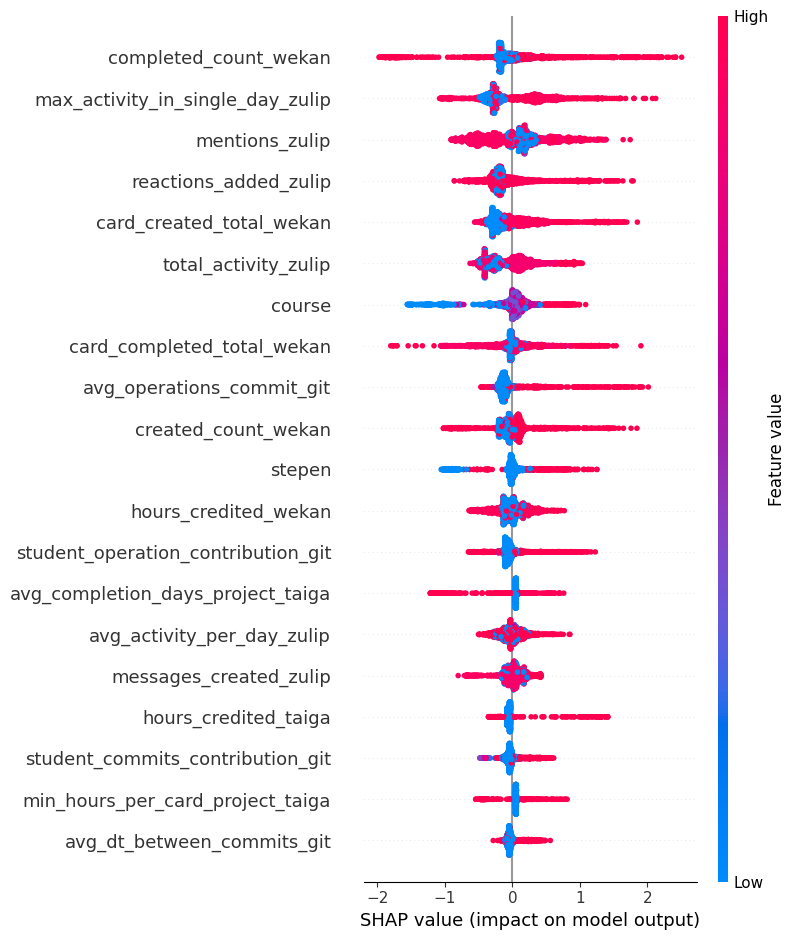

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_resampled)
shap.summary_plot(shap_values, X_resampled)


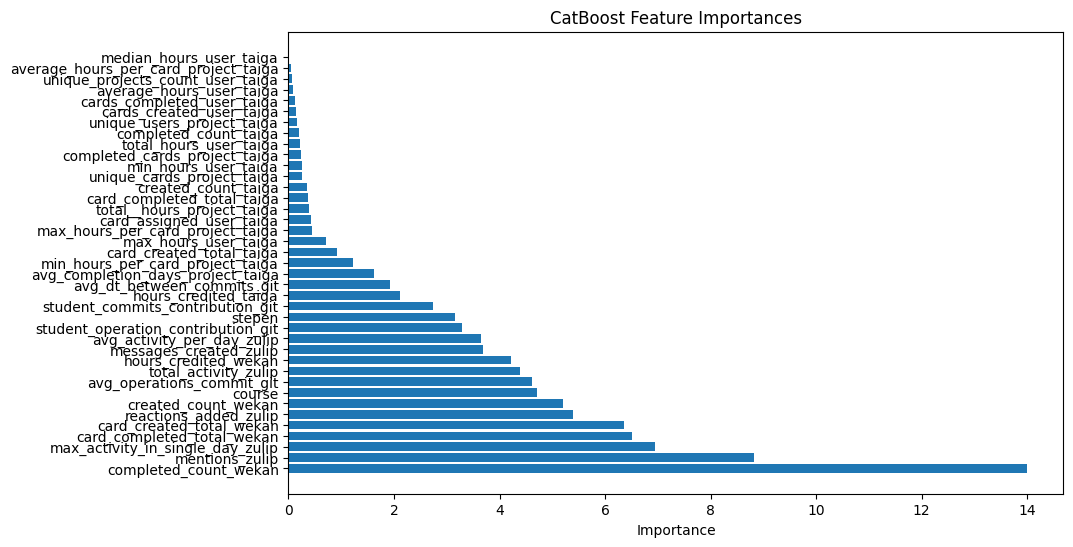

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(Pool(X_resampled, y_resampled, cat_features=cat_features))

x = (dict(zip(X_train.columns, importances)))
x = dict(sorted(x.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(10, 6))
plt.barh(x.keys(), x.values())
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


# SMOTE fillna 0

In [ ]:
df = pd.read_csv("./notna_df.csv", sep = ';', index_col=0)
drop_cols = ['isna', 'student_group','student_name', 'person_id', 'project_id', 'target_multiclass', 'rate_total', 'project_head']
df = df.drop(columns = drop_cols)

cat_features = ['stepen', 'course']
df[cat_features] = df[cat_features].astype(str)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:

from imblearn.over_sampling import SMOTE

cat_features = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [ ]:
cat_features = ['stepen', 'course']

task = 'smote_0'
model = CatBoostClassifier(
    random_seed=1,
    verbose=0
)

model.fit(X_resampled, y_resampled, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)


y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train,model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test,model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.99      0.98      0.99       907

    accuracy                           0.97       987
   macro avg       0.90      0.93      0.92       987
weighted avg       0.98      0.97      0.98       987

TEST
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        20
           1       0.93      0.95      0.94       227

    accuracy                           0.89       247
   macro avg       0.59      0.57      0.58       247
weighted avg       0.88      0.89      0.88       247

ROC-AUC train 0.990600882028666
ROC-AUC test 0.7176211453744493


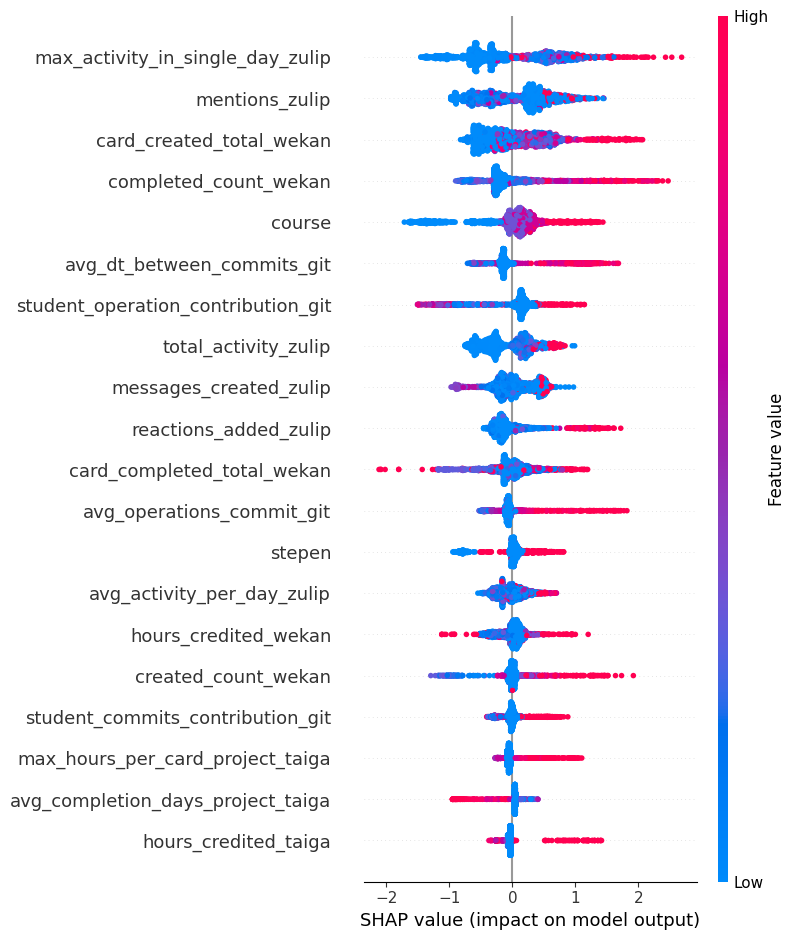

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_resampled)
shap.summary_plot(shap_values, X_resampled)


In [ ]:
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16
6,smote_-999_train,0.989899,0.972437,0.981090,0.987238,0.74,0.89,0.81
7,smote_-999_test,0.932735,0.916300,0.924444,0.713436,0.21,0.25,0.23
8,smote_0_train,0.990000,0.982359,0.986165,0.990601,0.82,0.89,0.85
9,smote_0_test,0.930736,0.947137,0.938865,0.717621,0.25,0.20,0.22


In [ ]:
! pip install optuna

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
import optuna
from sklearn.metrics import f1_score
import numpy as np

def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [50, 100, 250, 500]),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'class_weights': [trial.suggest_float('class_0_weight', 1, 20), 1],
        'random_seed': 42,
        'eval_metric': 'AUC',
        'logging_level': 'Silent',
        'loss_function': 'Logloss',
        'early_stopping_rounds': 50,
    }

    dataset = Pool(data=X_resampled, label=y_resampled, cat_features=cat_features)

    cv_result = cv(
        pool=dataset,
        params=params,
        fold_count=5,
        stratified=True,
        partition_random_seed=42,
        verbose=False,
        early_stopping_rounds=50,
        shuffle=True,
        metric_period=1
    )

    best_score = np.max(cv_result['test-AUC-mean']) 
    return best_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial.params)


[I 2025-04-20 10:17:32,096] A new study created in memory with name: no-name-80605009-7af8-4506-bf09-acdcc6c98ffc
[I 2025-04-20 10:17:33,724] Trial 0 finished with value: 0.8101954438582334 and parameters: {'iterations': 50, 'depth': 4, 'learning_rate': 0.0029762332471505123, 'l2_leaf_reg': 1.5448209381991704, 'class_0_weight': 6.339901341924091}. Best is trial 0 with value: 0.8101954438582334.
[I 2025-04-20 10:18:15,002] Trial 1 finished with value: 0.8472323415185825 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.0012689555735698613, 'l2_leaf_reg': 7.447125878943689, 'class_0_weight': 10.76235243978752}. Best is trial 1 with value: 0.8472323415185825.
[I 2025-04-20 10:18:58,151] Trial 2 finished with value: 0.8476609418309649 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.0025857834130748754, 'l2_leaf_reg': 8.531500239040454, 'class_0_weight': 18.56988338382878}. Best is trial 2 with value: 0.8476609418309649.
[I 2025-04-20 10:19:12,846] Trial 

Best trial:
{'iterations': 250, 'depth': 6, 'learning_rate': 0.09167660085172492, 'l2_leaf_reg': 3.73001599937758, 'class_0_weight': 3.695165740795553}


In [ ]:
print(study.best_trial.params)

{'iterations': 250, 'depth': 6, 'learning_rate': 0.09167660085172492, 'l2_leaf_reg': 3.73001599937758, 'class_0_weight': 3.695165740795553}


In [ ]:
model = CatBoostClassifier(**{'verbose':0, 'iterations': 250, 'depth': 6, 'learning_rate': 0.09167660085172492, 'l2_leaf_reg': 3.73001599937758, 'class_weights': [3.695165740795553, 1], 'early_stopping_rounds': 10, 'random_seed':42})

model.fit(X_resampled, y_resampled, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)

TRAIN
              precision    recall  f1-score   support

           0       0.36      0.99      0.53        80
           1       1.00      0.85      0.92       907

    accuracy                           0.86       987
   macro avg       0.68      0.92      0.72       987
weighted avg       0.95      0.86      0.89       987

TEST
              precision    recall  f1-score   support

           0       0.17      0.55      0.26        20
           1       0.95      0.77      0.85       227

    accuracy                           0.75       247
   macro avg       0.56      0.66      0.56       247
weighted avg       0.89      0.75      0.80       247

ROC-AUC train 0.9669514884233738
ROC-AUC test 0.7715859030837003


In [ ]:
task = 'smote_0_tuned'
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16
6,smote_-999_train,0.989899,0.972437,0.981090,0.987238,0.74,0.89,0.81
7,smote_-999_test,0.932735,0.916300,0.924444,0.713436,0.21,0.25,0.23
8,smote_0_train,0.990000,0.982359,0.986165,0.990601,0.82,0.89,0.85
9,smote_0_test,0.930736,0.947137,0.938865,0.717621,0.25,0.20,0.22


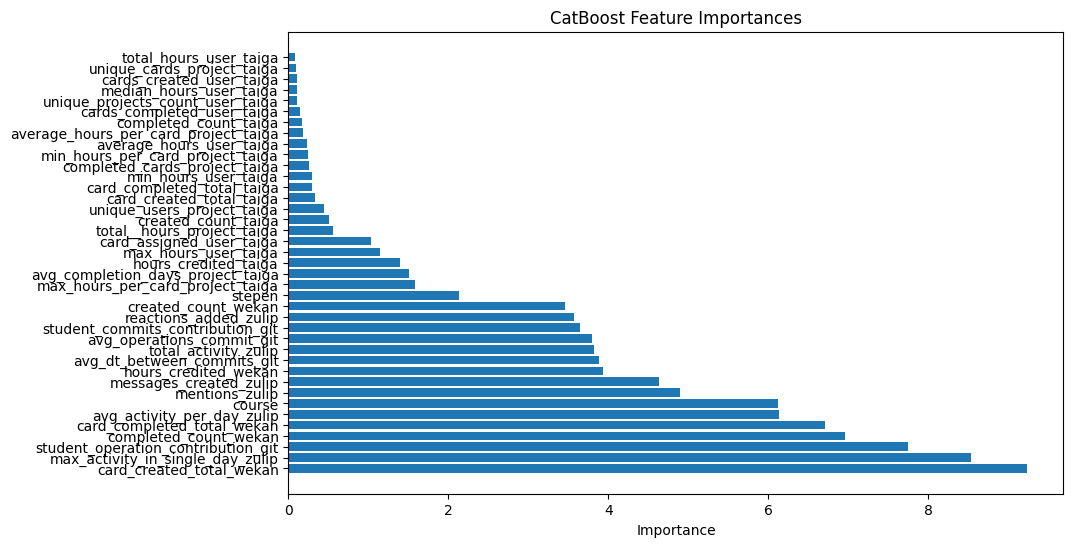

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(Pool(X_resampled, y_resampled, cat_features=cat_features))

x = (dict(zip(X_resampled.columns, importances)))
x = dict(sorted(x.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(10, 6))
plt.barh(x.keys(), x.values())
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


# tune baseline

In [ ]:
df = pd.read_csv("./notna_df.csv", sep = ';', index_col=0) 
drop_cols = ['isna', 'student_group','student_name', 'person_id', 'project_id', 'target_multiclass', 'rate_total', 'project_head']
df = df.drop(columns = drop_cols)

cat_features = ['stepen', 'course']
df[cat_features] = df[cat_features].astype(str)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
import optuna
from sklearn.metrics import f1_score
import numpy as np

def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [50, 100, 250, 500, 1000]),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'class_weights': [trial.suggest_float('class_0_weight', 1, 20), 1],
        'random_seed': 42,
        'eval_metric': 'AUC',
        'logging_level': 'Silent',
        'loss_function': 'Logloss',
        'early_stopping_rounds': 20,
    }

    dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)

    cv_result = cv(
        pool=dataset,
        params=params,
        fold_count=5,
        stratified=True,
        partition_random_seed=42,
        verbose=False,
        early_stopping_rounds=50,
        shuffle=True,
        metric_period=1
    )

    best_score = np.max(cv_result['test-AUC-mean']) 
    return best_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
print(study.best_trial.params)


[I 2025-04-20 10:43:29,973] A new study created in memory with name: no-name-1ccd25b4-71d9-4e2e-b282-6123317475f8
[I 2025-04-20 10:43:31,335] Trial 0 finished with value: 0.7042817679558012 and parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.0027713120587923553, 'l2_leaf_reg': 7.809406142201499, 'class_0_weight': 10.996907828664932}. Best is trial 0 with value: 0.7042817679558012.
[I 2025-04-20 10:43:35,059] Trial 1 finished with value: 0.724433473984579 and parameters: {'iterations': 100, 'depth': 7, 'learning_rate': 0.038509442119638256, 'l2_leaf_reg': 7.586283827385804, 'class_0_weight': 5.412544344482775}. Best is trial 1 with value: 0.724433473984579.
[I 2025-04-20 10:43:36,875] Trial 2 finished with value: 0.7155058511930059 and parameters: {'iterations': 50, 'depth': 7, 'learning_rate': 0.010530920268678209, 'l2_leaf_reg': 2.2768976806579695, 'class_0_weight': 12.750045836391271}. Best is trial 1 with value: 0.724433473984579.
[I 2025-04-20 10:43:39,087] Trial 3 f

Best trial:
{'iterations': 250, 'depth': 8, 'learning_rate': 0.09417512304541156, 'l2_leaf_reg': 6.554799228089358, 'class_0_weight': 8.150994846266489}


In [ ]:
task = 'baseline_class_weight_tuned'
model = CatBoostClassifier(**{'iterations': 250, 'depth': 8, 'learning_rate': 0.09417512304541156, 'l2_leaf_reg': 6.554799228089358, 'class_weights': [7.150994846266489, 1], 'random_seed':42, 'verbose':0})

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.46      0.93      0.61        80
           1       0.99      0.90      0.95       907

    accuracy                           0.90       987
   macro avg       0.72      0.91      0.78       987
weighted avg       0.95      0.90      0.92       987

TEST
              precision    recall  f1-score   support

           0       0.17      0.35      0.23        20
           1       0.94      0.85      0.89       227

    accuracy                           0.81       247
   macro avg       0.55      0.60      0.56       247
weighted avg       0.87      0.81      0.84       247

ROC-AUC train 0.9631684123484013
ROC-AUC test 0.755726872246696


In [ ]:
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics.to_csv('./metrics.csv')

In [ ]:
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16
6,smote_-999_train,0.989899,0.972437,0.981090,0.987238,0.74,0.89,0.81
7,smote_-999_test,0.932735,0.916300,0.924444,0.713436,0.21,0.25,0.23
8,smote_0_train,0.990000,0.982359,0.986165,0.990601,0.82,0.89,0.85
9,smote_0_test,0.930736,0.947137,0.938865,0.717621,0.25,0.20,0.22


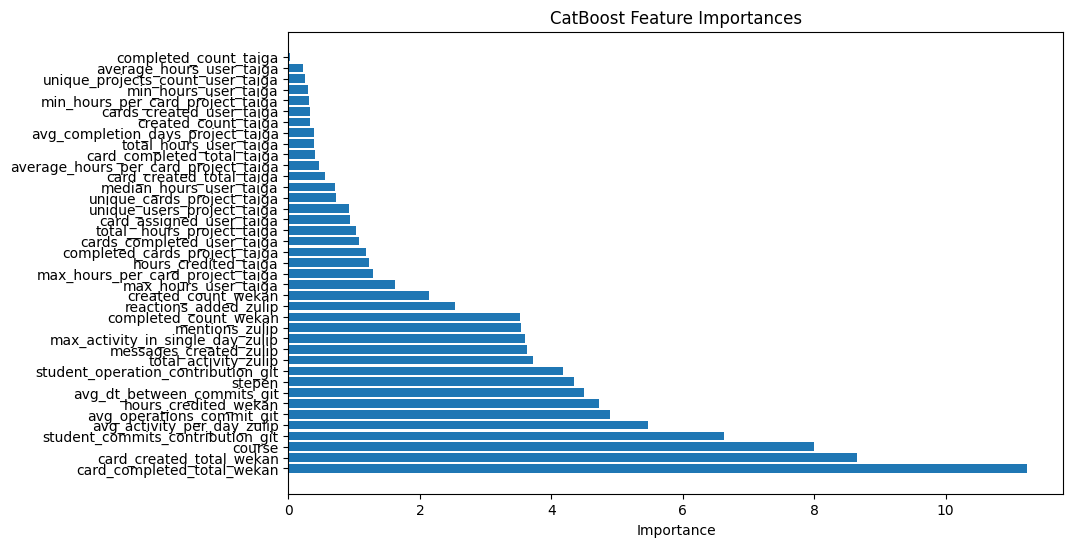

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))

x = (dict(zip(X_train.columns, importances)))
x = dict(sorted(x.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(10, 6))
plt.barh(x.keys(), x.values())
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
x

{'completed_count_taiga': np.float64(0.015839821861535576),
 'average_hours_user_taiga': np.float64(0.22703388837239946),
 'unique_projects_count_user_taiga': np.float64(0.24496061295548702),
 'min_hours_user_taiga': np.float64(0.30210456685040965),
 'min_hours_per_card_project_taiga': np.float64(0.30613235960512086),
 'cards_created_user_taiga': np.float64(0.3289677401001738),
 'created_count_taiga': np.float64(0.33017579063162733),
 'avg_completion_days_project_taiga': np.float64(0.3835059009375086),
 'total_hours_user_taiga': np.float64(0.38671405587166335),
 'card_completed_total_taiga': np.float64(0.40022390511487715),
 'average_hours_per_card_project_taiga': np.float64(0.4709570213911699),
 'card_created_total_taiga': np.float64(0.5607231425475372),
 'median_hours_user_taiga': np.float64(0.7131561745194229),
 'unique_cards_project_taiga': np.float64(0.7306864624134326),
 'unique_users_project_taiga': np.float64(0.9237334141402583),
 'card_assigned_user_taiga': np.float64(0.930380

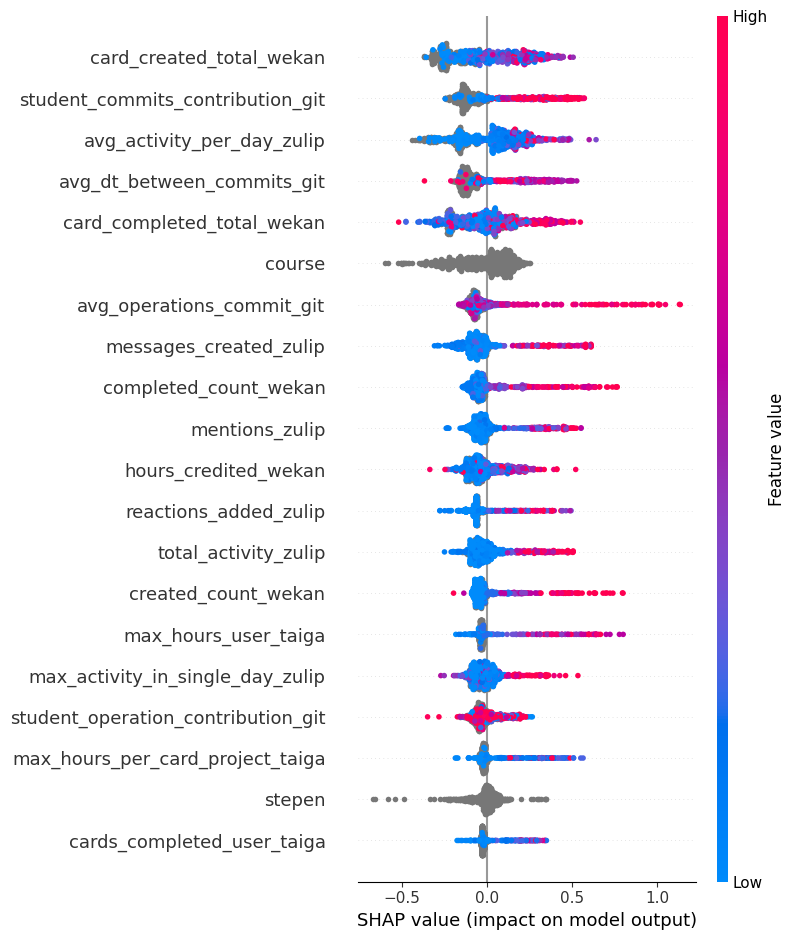

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)


# feature selection

In [ ]:
df = pd.read_csv("./notna_df.csv", sep = ';', index_col=0) 
drop_cols = ['isna', 'student_group','student_name', 'person_id', 'project_id', 'target_multiclass', 'rate_total', 'project_head']
df = df.drop(columns = drop_cols)

cat_features = ['stepen', 'course']
df[cat_features] = df[cat_features].astype(str)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cat_features = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))

train_pool = Pool(data=X_train, label=y_train)

model = CatBoostClassifier(**{'iterations': 250, 'depth': 8, 'learning_rate': 0.09417512304541156, 'l2_leaf_reg': 6.554799228089358,
                              'class_weights': [14.150994846266489, 1], 'random_seed':42, 'verbose':0})

try:
    summary = model.select_features(
        train_pool,
        num_features_to_select=15,
        features_for_select=list(range(X.shape[1])),
        verbose=False
    )
    print(f"Выбранные признаки: {summary['selected_features']}")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Step #1 out of 1
Feature #18 eliminated
Feature #24 eliminated
Feature #14 eliminated
Feature #25 eliminated
Feature #20 eliminated
Feature #13 eliminated
Feature #32 eliminated
Feature #23 eliminated
Feature #26 eliminated
Feature #34 eliminated
Feature #21 eliminated
Feature #28 eliminated
Feature #27 eliminated
Feature #16 eliminated
Feature #22 eliminated
Feature #33 eliminated
Feature #29 eliminated
Feature #19 eliminated
Feature #17 eliminated
Feature #36 eliminated
Feature #0 eliminated
Feature #15 eliminated
Feature #9 eliminated
Feature #35 eliminated
Train final model
Выбранные признаки: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 30, 31, 37, 38]


In [ ]:
X_train

,stepen,course,total_activity_zulip,reactions_added_zulip,messages_created_zulip,mentions_zulip,max_activity_in_single_day_zulip,avg_activity_per_day_zulip,created_count_wekan,completed_count_wekan,...,total__hours_project_taiga,avg_completion_days_project_taiga,max_hours_per_card_project_taiga,min_hours_per_card_project_taiga,average_hours_per_card_project_taiga,unique_users_project_taiga,avg_operations_commit_git,student_operation_contribution_git,avg_dt_between_commits_git,student_commits_contribution_git
1231,0,2,99.0,31.0,68.0,71.0,42.0,5.254386,NaN,NaN,...,1315.0,30.6,30.0,0.0,5.668103,12.0,NaN,NaN,NaN,NaN
21,0,2,6.0,1.0,5.0,4.0,15.0,5.666667,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1134,0,2,12.0,0.0,12.0,15.0,9.0,2.096774,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,0,3,1.0,0.0,1.0,4.0,4.0,1.714286,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.419384,1.0,0.588408,1.0
104,0,1,18.0,4.0,14.0,4.0,4.0,1.347826,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.250800,1.0,0.534955,1.0
800,0,1,3.0,1.0,2.0,0.0,2.0,1.333333,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.628999,1.0,0.687874,1.0
1569,0,1,11.0,0.0,11.0,6.0,4.0,1.529412,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,0,2,29.0,7.0,22.0,21.0,3.0,1.500000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sel = summary['selected_features']

model = CatBoostClassifier(**{'iterations': 250, 'depth': 8, 'learning_rate': 0.09417512304541156, 'l2_leaf_reg': 6.554799228089358, 'class_weights': [14.150994846266489, 1], 'random_seed':42, 'verbose':0})

model.fit(X_train, y_train, cat_features=['course'], eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.14      0.99      0.24        80
           1       1.00      0.45      0.62       907

    accuracy                           0.49       987
   macro avg       0.57      0.72      0.43       987
weighted avg       0.93      0.49      0.59       987

TEST
              precision    recall  f1-score   support

           0       0.13      0.85      0.23        20
           1       0.97      0.51      0.67       227

    accuracy                           0.53       247
   macro avg       0.55      0.68      0.45       247
weighted avg       0.91      0.53      0.63       247

ROC-AUC train 0.812617144432194
ROC-AUC test 0.710352422907489


In [ ]:
task = 'baseline_class_weight_tuned_15_sel_feats'

new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16
6,smote_-999_train,0.989899,0.972437,0.981090,0.987238,0.74,0.89,0.81
7,smote_-999_test,0.932735,0.916300,0.924444,0.713436,0.21,0.25,0.23
8,smote_0_train,0.990000,0.982359,0.986165,0.990601,0.82,0.89,0.85
9,smote_0_test,0.930736,0.947137,0.938865,0.717621,0.25,0.20,0.22


# selest 25 features

In [ ]:
df = pd.read_csv("./notna_df.csv", sep = ';', index_col=0) 
drop_cols = ['isna', 'student_group','student_name', 'person_id', 'project_id', 'target_multiclass', 'rate_total', 'project_head']
df = df.drop(columns = drop_cols)

cat_features = ['stepen', 'course']
df[cat_features] = df[cat_features].astype(str)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

cat_features = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))

train_pool = Pool(data=X_train, label=y_train)

model = CatBoostClassifier(**{'iterations': 250, 'depth': 8, 'learning_rate': 0.09417512304541156, 'l2_leaf_reg': 6.554799228089358, 'class_weights': [14.150994846266489, 1], 'random_seed':42, 'verbose':0})

try:
    summary = model.select_features(
        train_pool, 
        num_features_to_select=25,
        features_for_select=list(range(X.shape[1])),
        verbose=False
    )
    print(f"Выбранные признаки: {summary['selected_features']}")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Step #1 out of 1
Feature #18 eliminated
Feature #24 eliminated
Feature #14 eliminated
Feature #25 eliminated
Feature #20 eliminated
Feature #13 eliminated
Feature #32 eliminated
Feature #23 eliminated
Feature #26 eliminated
Feature #34 eliminated
Feature #21 eliminated
Feature #28 eliminated
Feature #27 eliminated
Feature #16 eliminated
Train final model
Выбранные признаки: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 17, 19, 22, 29, 30, 31, 33, 35, 36, 37, 38]


In [ ]:
model = CatBoostClassifier(**{'iterations': 250, 'depth': 8, 'learning_rate': 0.09417512304541156, 'l2_leaf_reg': 6.554799228089358, 'class_weights': [14.150994846266489, 1], 'random_seed':42, 'verbose':0})

model.fit(X_train, y_train, cat_features=['course'], eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, y_pred_train)
roc_test= roc_auc_score(y_test, y_pred)


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.24      0.99      0.39        80
           1       1.00      0.73      0.84       907

    accuracy                           0.75       987
   macro avg       0.62      0.86      0.61       987
weighted avg       0.94      0.75      0.80       987

TEST
              precision    recall  f1-score   support

           0       0.20      0.80      0.32        20
           1       0.98      0.71      0.82       227

    accuracy                           0.72       247
   macro avg       0.59      0.76      0.57       247
weighted avg       0.91      0.72      0.78       247

ROC-AUC train 0.8564842888643881
ROC-AUC test 0.7568281938325991


In [ ]:
task = 'baseline_class_weight_tuned_25_selected_features'

new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,baseline_train,0.924567,1.000000,0.960805,0.942930,1.00,0.07,0.14
1,baseline_test,0.922764,1.000000,0.959831,0.758590,1.00,0.05,0.10
2,baseline_class_weight_train,0.991935,0.678060,0.805501,0.877722,0.20,0.94,0.34
3,baseline_class_weight_test,0.975000,0.687225,0.806202,0.759251,0.18,0.80,0.30
4,drop_more_cols_train,0.979417,0.723701,0.832362,0.853649,0.21,0.83,0.33
5,drop_more_cols_test,0.929032,0.727273,0.815864,0.609923,0.10,0.35,0.16
6,smote_-999_train,0.989899,0.972437,0.981090,0.987238,0.74,0.89,0.81
7,smote_-999_test,0.932735,0.916300,0.924444,0.713436,0.21,0.25,0.23
8,smote_0_train,0.990000,0.982359,0.986165,0.990601,0.82,0.89,0.85
9,smote_0_test,0.930736,0.947137,0.938865,0.717621,0.25,0.20,0.22


In [ ]:
X_train

,stepen,course,total_activity_zulip,reactions_added_zulip,messages_created_zulip,mentions_zulip,max_activity_in_single_day_zulip,avg_activity_per_day_zulip,created_count_wekan,completed_count_wekan,...,total_hours_user_taiga,max_hours_user_taiga,total__hours_project_taiga,avg_completion_days_project_taiga,max_hours_per_card_project_taiga,average_hours_per_card_project_taiga,avg_operations_commit_git,student_operation_contribution_git,avg_dt_between_commits_git,student_commits_contribution_git
1231,0,2,99.0,31.0,68.0,71.0,42.0,5.254386,NaN,NaN,...,144.0,30.0,1315.0,30.6,30.0,5.668103,NaN,NaN,NaN,NaN
21,0,2,6.0,1.0,5.0,4.0,15.0,5.666667,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1134,0,2,12.0,0.0,12.0,15.0,9.0,2.096774,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,0,3,1.0,0.0,1.0,4.0,4.0,1.714286,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.419384,1.0,0.588408,1.0
104,0,1,18.0,4.0,14.0,4.0,4.0,1.347826,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.250800,1.0,0.534955,1.0
800,0,1,3.0,1.0,2.0,0.0,2.0,1.333333,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.628999,1.0,0.687874,1.0
1569,0,1,11.0,0.0,11.0,6.0,4.0,1.529412,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,0,2,29.0,7.0,22.0,21.0,3.0,1.500000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


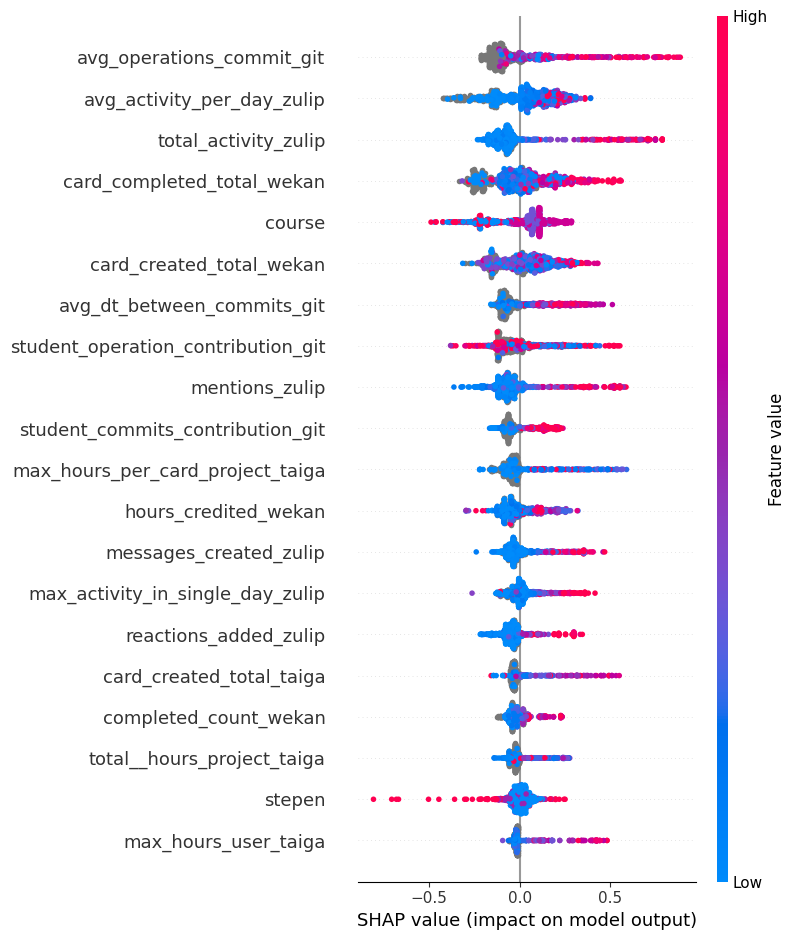

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)


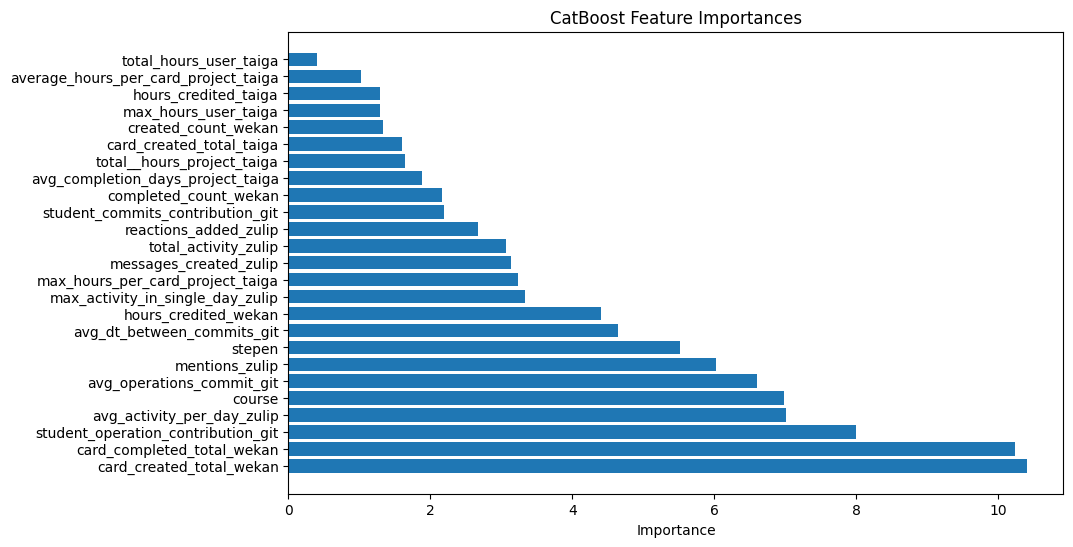

In [ ]:
import matplotlib.pyplot as plt

importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=['course']))

x = (dict(zip(X_train.columns, importances)))
x = dict(sorted(x.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(10, 6))
plt.barh(x.keys(), x.values())
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
x

{'total_hours_user_taiga': np.float64(0.3988346616324284),
 'average_hours_per_card_project_taiga': np.float64(1.0177300245176495),
 'hours_credited_taiga': np.float64(1.283775528970728),
 'max_hours_user_taiga': np.float64(1.2841382289365355),
 'created_count_wekan': np.float64(1.3275114181875498),
 'card_created_total_taiga': np.float64(1.6020556077085142),
 'total__hours_project_taiga': np.float64(1.6409074756451043),
 'avg_completion_days_project_taiga': np.float64(1.8760411286701042),
 'completed_count_wekan': np.float64(2.157906841532343),
 'student_commits_contribution_git': np.float64(2.1916162281212417),
 'reactions_added_zulip': np.float64(2.6698184795326374),
 'total_activity_zulip': np.float64(3.0571994413206856),
 'messages_created_zulip': np.float64(3.135909753533868),
 'max_hours_per_card_project_taiga': np.float64(3.232375276358752),
 'max_activity_in_single_day_zulip': np.float64(3.3386616868430137),
 'hours_credited_wekan': np.float64(4.399527724531978),
 'avg_dt_betw

In [ ]:
X_train.stepen.value_counts()

,count
stepen,
0,771
1,162
2,54


In [ ]:
metrics.round(2).to_csv('metris.csv', sep = ';')